# Sentiment Analysis of Bengali Texts
We will go through all the steps towards Sentiment Analaysis of Bengali Language with Deep Learning Model. 

There are very few published works on this topic. Specially when I was working with Sentiment Analysis of Bengali Language for my final year's thesis I didn't find any stuctured work that will lead me from scratch to results. So I am writting the code bellow that will lead from loading dataset to constructing model, to make prediction with te model.

Withot further discussion, let's dive into code. I will be writing the code in google colab. So if you run in your local environment make sure you have installed all the packages/modules. And All my files will be uploaded from drive. You can try it with your own dataset if you want.

First, let's Check if the colab GPU is connected, execute following code

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Let's import neessary libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,Conv1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer



seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# BNLP Toolkit

Before feeding data to a Neural Network, we need to prepare the data for the neural network. To remove noise from the data, and to make it fit for the neural network, we will go throuth several steps 

In the first steps of prepocessing, BNLP tool kit will help us. We will use it for POS tagging, punctuation removal.

In [ ]:
!pip install bnlp_toolkit


     |████████████████████████████████| 1.2MB 37.5MB/s 
     |████████████████████████████████| 23.9MB 116kB/s 
     |████████████████████████████████| 747kB 39.1MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
print(tf.keras.__version__)
print(tf.__version__)
!python --version

2.5.0
2.5.0
Python 3.7.10


# Dataset
The following blocks will load the dataset and we'll se their shapes.

I have used "Bengali Book Review Dataset" which was published by E. Hossain and his team. Thanks to them. Go google for it and you will find the dataset. I am not providing the original dataset here for some reason.


N.B.: I am loading data from my google drive. Make sure you give appropriate path to your dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
movie_reviews = pd.read_excel(r"/content/drive/My Drive/Thesis/bookReviews_2000.xlsx")

movie_reviews.isnull().values.any()

movie_reviews.shape

(2011, 3)

In [ ]:
movie_reviews.head()

,Unnamed: 0,Review,Sentiment
0,0,বই টি আমার সংগ্রহে আছে এবং তা আমি পড়েছি। বই টি...,0
1,1,ফালতু বই। শুধু শুধু টাকা নষ্ট।,0
2,2,"একটু পড়ে দেখতে বলসিলো, একটু পড়লাম। তারপর হড়হড় ...",0
3,3,এটা কোন বই? ছিঃ ধিকার জানায়। প্রশাসনের নজর দেয়...,0
4,4,"প্রিয় রকমারি.কম, দয়া করে বইটি আপনাদের ওয়েবসাইট...",0


In [ ]:
#movie_reviews["Text"][3]

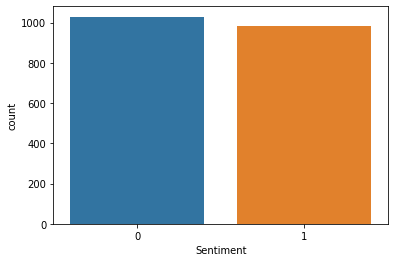

In [ ]:
import seaborn as sns

sns_plot=sns.countplot(x='Sentiment', data=movie_reviews)
fig = sns_plot.get_figure()
fig.savefig("data_shape.png")

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
Z=[]
Sent=[]
sentence_tokens_list = []
word_tokens_list = []
pos_tags_list = []
sentences = []

sentence_tokens_list.clear()
word_tokens_list.clear()
pos_tags_list.clear()
sentences.clear()


sentence = list(movie_reviews['Review'])

for sen in sentence:
    sentences.append(preprocess_text(sen))


In [ ]:
print(sentences[:5])

['বই টি আমার সংগ্রহে আছে এবং তা আমি পড়েছি। বই টি সম্পর্কে যদি এক কথায় বলতে হয় তবে বলবো মন্দের ভালো । খুবই সাধারন মানের আলোচনা করা হয়েছে ফরেক্স নিয়ে,তবে অপ্রয়োজনীয় গল্প লিখে আর নিজের প্রকাশিত বইয়ের বিজ্ঞাপন দিযে বইয়ের পেজের সংখ্যা বাড়ানো হয়েছে শুধু , কয়েকটি উদাহরন দিলে বুঝতে পারবে : ফরেন রেমিটেন্স কি,কিভাবে দেশের কাজে লাগে,কিভাবে ইমেল এড্রেস খুলতে হয় এসব আলাপ করা হয়েছে, কিন্তু লেখক তার বই তে ডিফল্ট করা কোন ইন্ডিকেটর,ই.এ,ট্রেডিং প্ল্যান, মানি মেনেজমেন্টে ইত্যাদি নিয়ে এক বর্ন আলোচনা করেন নাই। এমন কি ট্রেডিং প্লাটফর্মের বিভিন্ন অপশন নিয়ে দায়সারা বর্নণা দিয়েছেন, সাথে রয়েছে অসংখ্য বানান ভুল। বইয়ের ৪৭৯ টি পেজের মধ্য ৩২২ থেকে ৪৭৯ নাম্বার পেজ পর্যন্ত ১৫৭ টি পেজে যা রয়েছে তা ‘অতিকথন’ বা “পুনরায় প্রচার” ছাড়া কিছুই না ।একটি টিউটোরিয়াল সিডি দেয়া হয়েছে, তা অতি স্বল্প আলোচনা করা হয়েছে।', 'ফালতু বই। শুধু শুধু টাকা নষ্ট।', 'একটু পড়ে দেখতে বলসিলো, একটু পড়লাম। তারপর হড়হড় করে বমি করে দিলাম। কেনার সাহস পাই নি। রিভিউতে আর নাই গেলাম। অনেকে রিভিউ দিছে। শুধু এইটুকু বলবো, দিনশেষে এদের রিভিউ দিয়ে থামানো যাবেনা। 

In [ ]:
# X.clear()

Z.clear()

Sent.clear()


# POS tagging and Punctuation Removal

In the following code, we will first have word tokens from each sentance with the help of BNLP toolkit. Then with POS tagging, we'll detect punctuations and remove them. 

In [ ]:
import nltk
nltk.download('punkt')
# X.clear()
Z.clear()
local_pos_tags = []
local_pos_tags.clear()
pos_tags_list.clear()

import copy ## to implement shallow copy. See copy in python

from bnlp import NLTKTokenizer
from bnlp import POS
bn_pos = POS()
model_path = "/content/drive/My Drive/Thesis/bn_pos_model.pkl"
for i in range(len(sentences)):
    text = sentences[i]
    bnltk = NLTKTokenizer()
    
    
    word_tokens = bnltk.word_tokenize(text)
    word_tokens_copy = copy.copy(word_tokens)
#     word_tokens_list.append(word_tokens)
    
    
    sentence_tokens = bnltk.sentence_tokenize(text)
    sentence_tokens_list.append(sentence_tokens)
    
    for j in range(len(word_tokens)):
        word = word_tokens[j]    
        pos_tags = bn_pos.tag(model_path, word)
        
        if(pos_tags[0][1] == "PU"):
            word_tokens_copy.remove(str(word))

            
    word_tokens_list.append(word_tokens_copy)

            

print("\n Sentence Tokens")
print(sentence_tokens_list[:3])

print("\n Word Tokens")
print(word_tokens_list[:3])




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



 Sentence Tokens
[['বই টি আমার সংগ্রহে আছে এবং তা আমি পড়েছি।', 'বই টি সম্পর্কে যদি এক কথায় বলতে হয় তবে বলবো মন্দের ভালো ।', 'খুবই সাধারন মানের আলোচনা করা হয়েছে ফরেক্স নিয়ে,তবে অপ্রয়োজনীয় গল্প লিখে আর নিজের প্রকাশিত বইয়ের বিজ্ঞাপন দিযে বইয়ের পেজের সংখ্যা বাড়ানো হয়েছে শুধু , কয়েকটি উদাহরন দিলে বুঝতে পারবে : ফরেন রেমিটেন্স কি,কিভাবে দেশের কাজে লাগে,কিভাবে ইমেল এড্রেস খুলতে হয় এসব আলাপ করা হয়েছে, কিন্তু লেখক তার বই তে ডিফল্ট করা কোন ইন্ডিকেটর,ই.এ,ট্রেডিং প্ল্যান, মানি মেনেজমেন্টে ইত্যাদি নিয়ে এক বর্ন আলোচনা করেন নাই।', 'এমন কি ট্রেডিং প্লাটফর্মের বিভিন্ন অপশন নিয়ে দায়সারা বর্নণা দিয়েছেন, সাথে রয়েছে অসংখ্য বানান ভুল।', 'বইয়ের ৪৭৯ টি পেজের মধ্য ৩২২ থেকে ৪৭৯ নাম্বার পেজ পর্যন্ত ১৫৭ টি পেজে যা রয়েছে তা ‘অতিকথন’ বা “পুনরায় প্রচার” ছাড়া কিছুই না .একটি টিউটোরিয়াল সিডি দেয়া হয়েছে, তা অতি স্বল্প আলোচনা করা হয়েছে।'], ['ফালতু বই।', 'শুধু শুধু টাকা নষ্ট।'], ['একটু পড়ে দেখতে বলসিলো, একটু পড়লাম।', 'তারপর হড়হড় করে বমি করে দিলাম।', 'কেনার সাহস পাই নি।', 'রিভিউতে আর নাই গেলাম।', 'অনেকে রিভিউ দিছে।', 'শুধু

In [ ]:
## We are creating word tokens first in 'word_tokens' . Then a shallow copy is made of 'word_tokens' to 
## 'word_tokens_copy'. We then check the POS tag of the tokens and if any one of them is "PU" (i.e punctuation)
## then we remove it from 'word_tokens_copy'. After iterating through all the tokens (hence removing all the "PU")
## we add 'word_tokens_copy' to 'word_tokens_list' .

## All these mess is done to remove the error 'list index out of range' while removing an element

In [ ]:
import copy
copy_of_word_tokens_list = [] ## It is costly to compute "word_tokens_list".
                            ## So I'm keeping an copy so that I can experiment with one and change it as wish
copy_of_word_tokens_list.clear()
copy_of_word_tokens_list = copy.copy(word_tokens_list)

In [ ]:
word_tokens_list = copy.copy(copy_of_word_tokens_list)

While removing punctations, there were some english sentence and they were removed. So, with the following block, I'm removing those empty arrays. In this way, we have no english sentance in the dataset. The dataset consists of only the Bangla Sentences.

In [ ]:


remove_counter = 0  ## to check if any array is removed for being empty
token_lngth = 0
token_length = len(word_tokens_list) ## to iterate over the whole "word_tokens_list" array
empty_positions = [] ## keep track of empty positions
empty_positions.clear()
print(token_length) ## How many positions are empty actually 

for i in range(token_length):
    if(len(copy_of_word_tokens_list[i]) == 0):
        word_tokens_list.pop(i)
        empty_positions.append(i)
        remove_counter += 1
        print("a")
        
        
print(remove_counter)

2011
a
a
2


In [ ]:
print(len(word_tokens_list))

print(len(sentence_tokens_list))


2009
2011


# Word2vec

Now we will generate our own wordvector model from all the words in our dataset which will be used laater to generate embeddding matrix. If are new and don't know about what wordvector and embedding matrix are, please go google it, you will have some great help.


To generate wordvector model, we'll use gensim word2vec with skip-gram model.

In [ ]:
#word2vec
import json
import os
import re
import string
import numpy as np

from gensim.models import Word2Vec


In [ ]:
model1 =Word2Vec(word_tokens_list, vector_size=100, window=15, min_count=1,sg=0)
#model2 =Word2Vec.load('bn_w2v_model.text')
model1.wv.save_word2vec_format("/content/drive/My Drive/Thesis/myword2vec_model.txt")

Let's see an example how words are stored in wordvector

In [ ]:
model1.wv["ভালো"]


array([-1.1438344e+00,  7.3054945e-01, -8.7438576e-02,  1.0434573e-01,
        2.7260277e-01, -1.7529709e+00,  3.7019753e-01,  1.6869632e+00,
       -2.1160957e-01, -3.6428714e-01, -1.8073250e-01, -1.4348829e+00,
       -5.5754269e-03,  4.7219008e-01,  1.4502580e-01, -1.1239703e+00,
       -5.2230485e-02, -1.4303710e+00,  4.5375493e-01, -1.6870745e+00,
        1.0331979e+00,  4.6281594e-01, -2.4726075e-01, -5.9194690e-01,
       -1.7322426e-01, -2.7670780e-02, -1.0036927e+00, -4.3307734e-01,
       -9.6143448e-01, -6.9311666e-01,  1.3974583e+00,  3.9957961e-01,
        8.9171439e-01, -6.8926048e-01, -5.2386121e-04,  6.2741798e-01,
       -7.4297301e-02, -4.7375783e-01, -4.6892610e-01, -1.6833508e+00,
        1.4988506e-01, -9.8816776e-01, -5.0224972e-01,  3.1082770e-01,
        7.0853299e-01, -4.9724510e-01, -2.5598937e-01,  6.3051716e-03,
        7.0528722e-01,  5.1920050e-01,  5.3578210e-01, -6.3927805e-01,
        4.1061541e-01,  3.8178885e-01, -3.7251264e-01,  3.2754481e-01,
      

In [ ]:
y = movie_reviews['Sentiment']

print(len(y))


2011


In the following block, we'll remove the label of corresponding english sentances from dataset, as we have removed them previously.

In [ ]:

for i in range(len(empty_positions)):
    y.pop(empty_positions[i])

print(len(y))


2009


# Train-Test Split

now we'll devide the total data into train and test set. I hae taken 10% data for test. Feel free to chose the percentage as you choice

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(word_tokens_list, y, test_size=0.10, random_state=42)

print(X_train[:5])
print(y_train[:5])

[['বইটি', 'খুবই', 'তথ্য', 'বহুল', 'ও', 'সময়োপযোগী', 'আমার', 'খুবই', 'ভালো', 'লেগেছে'], ['অপেক্ষা', 'একটি', 'নিন্ম', 'মানের', 'উপন্যাস', 'অনেকটা', 'ইন্ডিয়ান', 'বাংলা', 'সিরিয়াল', 'এর', 'মত', 'ছোট', 'একটি', 'সংলাপ', 'কে', 'টেনে', 'হিছড়ে', 'লম্বা', 'করা', 'হয়েছে', 'তাও', 'খুব', 'বাজে', 'ভাবে', 'এর', 'ফোন', 'অালাপ', 'এ', 'না', 'হতো', 'এটা', 'বেশি', 'হয়ে', 'গেছে', 'খুবই', 'কাচা', 'লেখা', 'এটা', 'যে', 'লেখক', 'এর', 'উপন্যাস', 'সেটা', 'তার', 'লেখাতে', 'স্পষ্ট', 'অার', 'অনেক', 'জায়গায়', 'অসংগতি', 'রয়েছে', 'সব', 'মিলিয়ে', 'অপেক্ষা', 'অামার', 'শুধু', 'অাক্ষেপ', 'ই', 'বাড়িয়েছে'], ['এই', 'বই', 'কোনো', 'মেয়েই', 'পড়তে', 'স্বাচ্ছন্দ্য', 'বোধ', 'করবে', 'না', 'কোনো', 'মেয়েই', 'তার', 'পরিচিত', 'মানুষজনদের', 'বলতে', 'পারবে', 'না', 'যে', 'এই', 'বইটি', 'পড়ুন', 'অশ্লীল', 'নোংরা', 'ও', 'ফালতু', 'একটা', 'বই'], ['দক্ষতা', 'আর', 'অভিজ্ঞতা', 'দুইটা', 'ভিন্ন', 'জিনিস', 'দুইটাকে', 'আপনি', 'যখন', 'সমান', 'তালে', 'কাজে', 'লাগাতে', 'পারবেন', 'তখনই', 'আপনি', 'একজন', 'সাধারণ', 'জীবন', 'থেকে', 'অসাধারণ', 'জীবন', 'লাভের'

In [ ]:
print(len(X_train))

len(X_test)

1808


201

# Tokenization

Neural networks can only work with numbers. But all we have are texts. So to feed them into neural-net, we must convert them to numbers. With Tokenizzation we have done it in the following block. Again, if you don't know what tokenization is, go search for it. 

In [ ]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Let's see the result of tokenization with an example

In [ ]:

X_train[:5]

[[5, 42, 211, 1165, 37, 1166, 9, 42, 11, 51],
 [330,
  6,
  3065,
  391,
  96,
  509,
  1925,
  103,
  1435,
  20,
  82,
  153,
  6,
  3066,
  91,
  745,
  3067,
  1926,
  35,
  32,
  849,
  15,
  108,
  136,
  20,
  976,
  3068,
  63,
  4,
  468,
  69,
  62,
  97,
  179,
  42,
  1927,
  34,
  69,
  18,
  36,
  20,
  96,
  157,
  29,
  1928,
  1929,
  1930,
  13,
  331,
  3069,
  230,
  60,
  469,
  330,
  1436,
  133,
  3070,
  240,
  1931],
 [2,
  1,
  145,
  1932,
  77,
  3071,
  656,
  137,
  4,
  145,
  1932,
  29,
  1933,
  3072,
  106,
  551,
  4,
  18,
  2,
  5,
  1167,
  1168,
  850,
  37,
  138,
  16,
  1],
 [1437,
  17,
  552,
  977,
  978,
  439,
  1934,
  98,
  163,
  3073,
  3074,
  241,
  1935,
  353,
  1169,
  98,
  101,
  315,
  248,
  28,
  25,
  248,
  1170,
  3075,
  3076,
  2,
  1934,
  40,
  136,
  3077,
  8,
  440,
  231,
  157,
  256,
  3078,
  851,
  1936,
  104,
  42,
  40,
  136,
  510,
  605,
  1937,
  15,
  413,
  365,
  35,
  354,
  5,
  139,
  3,
  42,
  

# Padding

Padding is necessary as input to a neural network is alwaya fixed sized. But the sentences we are working on are of different lengths. With padding, we add extra zeros to make them of the same length. 
I have used post padding and set pad length to 100.  

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

# print(vocab_size)

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
X_train[:5]

array([[   5,   42,  211, 1165,   37, 1166,    9,   42,   11,   51,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 330,    6, 3065,  391,   96,  509, 1925,  103, 1435,   20,   82,
         153,    6, 3066,   91,  745, 3067, 1926,   35,   32,  849,   15,
         108,  136,   20,  976, 3068,   63,    4,  468,   69,   62,   97,
         179,   42, 1927,   34,   69,   18,   36,   20,   96,  157,   29,
        1928, 1929, 193

# Embedding matrix

Now we'll generate our embedding matrix. We'll use our previously generated wordvector model to generate the embedding matrix which will later be used in the embedding layer of our Neural Network.

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/Thesis/myword2vec_model.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')

    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():

    embedding_vector = embeddings_dictionary.get(word)

    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
embedding_matrix[10]


array([-1.31697488,  0.86575234, -0.08007181,  0.10611926,  0.32584873,
       -2.0445683 ,  0.44457504,  1.98733318, -0.24773337, -0.41965625,
       -0.20906639, -1.69857574,  0.05807006,  0.54387993,  0.18161957,
       -1.33498001, -0.05315037, -1.66534376,  0.52957875, -1.97150922,
        1.1987983 ,  0.52441549, -0.26637289, -0.6914677 , -0.23966518,
       -0.01377133, -1.14439964, -0.53149259, -1.12472725, -0.79875064,
        1.61752141,  0.46428043,  1.04433656, -0.80730581,  0.01385909,
        0.74429929, -0.08574194, -0.60174358, -0.58057868, -2.0069859 ,
        0.16885157, -1.1763531 , -0.6054945 ,  0.37554392,  0.8178888 ,
       -0.5819999 , -0.30692679, -0.01323455,  0.80677122,  0.5854584 ,
        0.6129126 , -0.78536528,  0.45565128,  0.39940235, -0.45558149,
        0.38953075,  0.58301276, -0.00640096, -0.9076162 ,  1.18094838,
        0.58840501,  0.50190049, -0.78913468, -0.18651257, -0.59567571,
        0.46508354, -0.21308222,  1.05253685, -0.88981277,  1.26

# Neural Network / Deep Learning model.\

All of our prerpocessing tasks are done! Now we'll build our deep learning model which will perform sentiment analysis for us. 

In my model, I have used a combination of CNN and RNN Layers with the Dense layers. 

I had done some hyper-parameter tuning for my model. Feel free to use your won model/layers/parameter as you want. This part is totally on you.

In [1]:
from keras import Sequential, optimizers
from keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional,ConvLSTM2D,GRU,SimpleRNN,RNN
from keras import regularizers

model2 = Sequential()
embedding_layer = Embedding(vocab_size, 100,weights=[embedding_matrix], input_length=maxlen , trainable=True)
model2.add(embedding_layer)

model2.add (Bidirectional(LSTM(64,  return_sequences=True,kernel_regularizer=regularizers.l2(0.15))))

model2.add(Conv1D(32, 4, activation='relu'))
model2.add (LSTM(32,return_sequences=True, activation = 'tanh') )

model2.add(Conv1D(16, 4, activation='relu'))

model2.add(GlobalMaxPooling1D())

model2.add (Dropout(0.4))

model2.add(Dense(16,activation='relu'))


model2.add(Dense(1, activation='sigmoid'))


opt = optimizers.Adam(learning_rate=0.0001)
#lr=0.0005
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])



NameError: ignored

Let's see the model's summary

In [ ]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          820800    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 100, 128)          84480     
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 97, 32)            16416     
_________________________________________________________________
lstm_21 (LSTM)               (None, 97, 32)            8320      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 94, 16)            2064      
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 16)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)              

# Train the model

And train the model with our training data. Again, feel free to chose the batch_size, epochs etc as you wish.

In [ ]:
history = model2.fit(X_train, y_train, batch_size=32, epochs=70, verbose=1, validation_split=0.10)

score = model2.evaluate(X_test, y_test, verbose=1)

Epoch 1/70
51/51 [==============================] - 7s 55ms/step - loss: 42.3759 - acc: 0.5262 - val_loss: 38.7907 - val_acc: 0.4972
Epoch 2/70
51/51 [==============================] - 2s 30ms/step - loss: 37.6770 - acc: 0.5336 - val_loss: 34.4743 - val_acc: 0.5083
Epoch 3/70
51/51 [==============================] - 2s 29ms/step - loss: 33.4769 - acc: 0.5682 - val_loss: 30.6185 - val_acc: 0.5249
Epoch 4/70
51/51 [==============================] - 1s 29ms/step - loss: 29.7262 - acc: 0.5681 - val_loss: 27.1711 - val_acc: 0.5470
Epoch 5/70
51/51 [==============================] - 1s 29ms/step - loss: 26.3711 - acc: 0.5797 - val_loss: 24.0880 - val_acc: 0.5912
Epoch 6/70
51/51 [==============================] - 1s 29ms/step - loss: 23.3757 - acc: 0.5529 - val_loss: 21.3323 - val_acc: 0.5912
Epoch 7/70
51/51 [==============================] - 1s 29ms/step - loss: 20.6896 - acc: 0.5862 - val_loss: 18.8714 - val_acc: 0.5912
Epoch 8/70
51/51 [==============================] - 1s 29ms/step - lo

# Plot the model's performance

The following block will generate model's accuracy and loss graph with training and validation data.

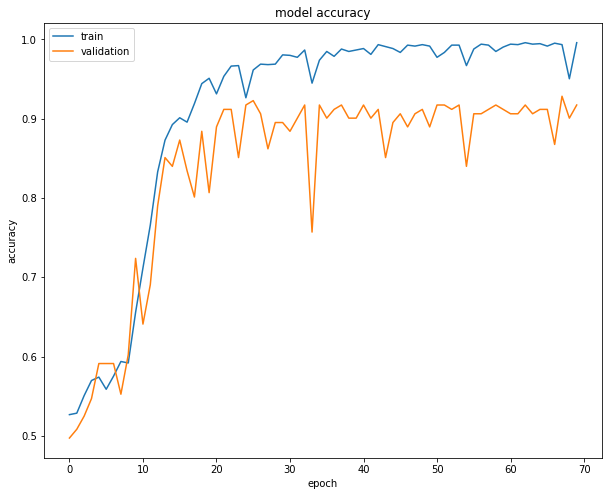

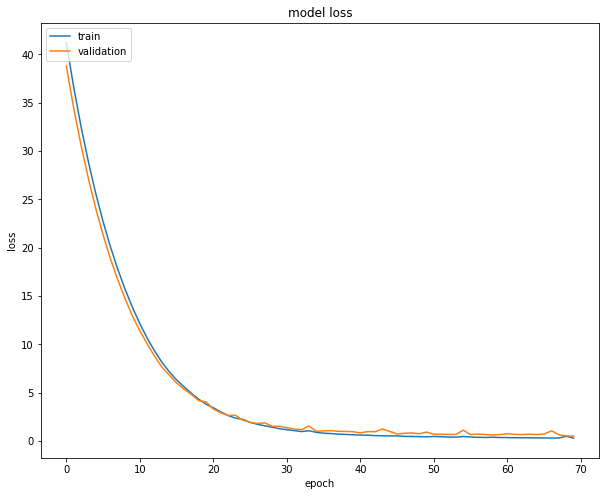

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('/content/drive/My Drive/Thesis/model_Accuracy.png',dpi=600)

plt.show()


plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('/content/drive/My Drive/Thesis/model_loss.png', dpi=600)

plt.show()

# Accuracy measures 

Now we will test our model with the test data that our model has never seen. 

We will check the accuracy, recall, precision and f-1 score.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score



yhat_classes = model2.predict_classes(X_test, verbose=1)
yhat_classes = yhat_classes[:, 0]
accuracy = accuracy_score(y_test, yhat_classes)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)



# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)


# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)



# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)



7/7 [==============================] - 0s 12ms/step
Accuracy: 0.925373
Precision: 0.930693
Recall: 0.921569
F1 score: 0.926108
[[92  7]
 [ 8 94]]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Confusion Matrix

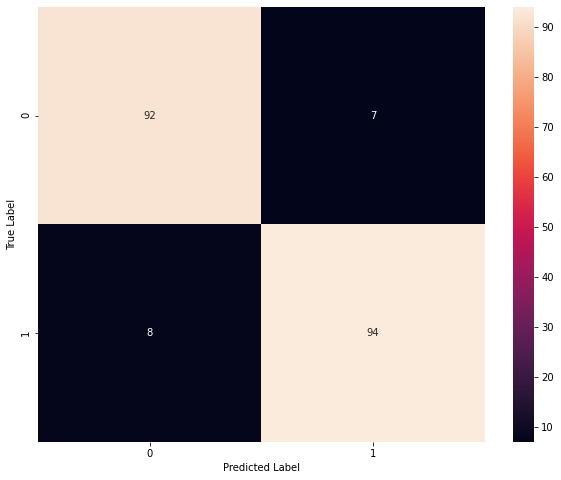

In [ ]:
# confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, xticklabels='01', yticklabels='01', annot=True, fmt='g')


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/My Drive/Thesis/confussion_matrix.png', dpi=600)

plt.show()

# ROC curve

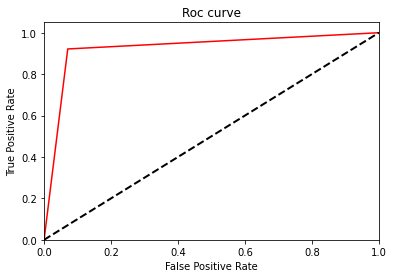

In [ ]:
fpr, tpr, _ = roc_curve(y_test,yhat_classes)
# plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.savefig('/content/drive/My Drive/Thesis/roc_curve.png', dpi=600)

plt.show()